In [1]:
from TimeTagger import *

import asyncio
import numpy as np
from ipywidgets import Button
import plotly.graph_objs as go

In [2]:
# connect to the TimeTagger
tagger = createTimeTagger()

# enable the internal test signal on channels 
tagger.setTestSignal(1, True)

In [3]:
# create a counter with 100 ms binwidth and one bin and 
trace = Counter(tagger, [1], 10**9, 1000)

# create a figure widget and a plot
fig_trace = go.FigureWidget()
fig_trace.add_scatter(x=trace.getIndex(), y=trace.getData()[0])

async def update_trace():
    """Update the plot every 0.1 s"""
    while True:
        fig_trace.data[0].y = trace.getData()[0]
        await asyncio.sleep(0.1)

# If this cell is re-excecuted and there was a previous task, stop it first to avoid a dead daemon
try:
    task_trace.cancel()
except:
    pass
loop = asyncio.get_event_loop()
task_trace = loop.create_task(update_trace())
    
# create a stop button
button_trace = Button(description='stop')
button_trace.on_click(lambda a: task_trace.cancel())

display(fig_trace,button_trace)


FigureWidget({
    'data': [{'type': 'scatter',
              'uid': '57997cdc-d7de-4a61-94da-cdab3f9759ee',
              'x': array([           0,   1000000000,   2000000000, ..., 997000000000,
                          998000000000, 999000000000], dtype=int64),
              'y': array([  0,   0,   0, ..., 841, 840, 840], dtype=int32)}],
    'layout': {'template': '...'}
})

Button(description='stop', style=ButtonStyle())

In [4]:
# create a counter with 100 ms binwidth and one bin and 
point = Counter(tagger, [1], 10**11, 1)

# create a figure widget and a plot
fig_bar = go.FigureWidget()
fig_bar.add_bar(x=point.getIndex(), y=point.getData()[0])
fig_bar.layout.yaxis={'range':[0,100000]}

async def update_bar():
    """Update the plot every 0.1 s"""
    while True:
        fig_bar.data[0].y = point.getData()[0]
        await asyncio.sleep(0.1)

# If this cell is re-excecuted and there was a previous task, stop it first to avoid a dead daemon
try:
    task_bar.cancel()
except:
    pass
loop = asyncio.get_event_loop()
task_bar = loop.create_task(update_bar())

# create a stop button
button_bar = Button(description='stop')
button_bar.on_click(lambda a: task_bar.cancel())

display(fig_bar, button_bar)


FigureWidget({
    'data': [{'type': 'bar',
              'uid': '0bd6d121-92e1-4096-afcb-2727adef9355',
              'x': array([0], dtype=int64),
              'y': array([0], dtype=int32)}],
    'layout': {'template': '...', 'yaxis': {'range': [0, 100000]}}
})

Button(description='stop', style=ButtonStyle())

In [5]:
import matplotlib.pyplot as plt

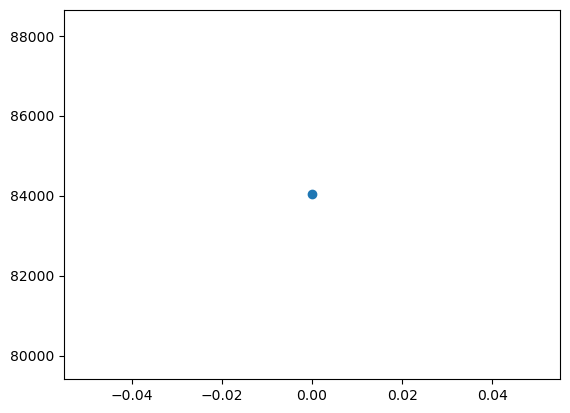

In [6]:
plt.plot(point.getIndex(), point.getData()[0], 'o')

In [7]:
point.getIndex(), point.getData()[0]

(array([0], dtype=int64), array([84025], dtype=int32))

In [11]:
import logging
import asyncio
import os
from PyQt5 import QtCore, QtGui, QtWidgets
from TimeTagger import createTimeTagger, Counter, \
                       Countrate, Histogram, LOW, \
                       HIGH, freeTimeTagger, scanTimeTagger, \
                       ConstantFractionDiscriminator
import numpy as np
import datetime
import tqdm
from time import sleep
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.backends.backend_qt5agg import NavigationToolbar2QT as NavigationToolbar
from matplotlib.figure import Figure
import matplotlib.pyplot as plt

#import logging
#logger = logging.getLogger(__name__)

#laser_room_ip = "192.168.169.49"
#SIGNALID = 270835


class HistogramDock(QtWidgets.QDockWidget):
    def __init__(self, tagger):
        super().__init__()
        self.setup_layout()
        self.tagger = tagger



    def plot_histogram(self):
        wait_times = np.logspace(3, 6, 10) * 1E-6 # in s
        wait_times_random = wait_times
        #print (wait_times)
        np.random.shuffle(wait_times_random)
        #print (wait_times_random)

        t_wait = 10E-6 # in us
        wait_times_random = [t_wait]
        cycle_duration = 112.2E-6 + t_wait # count this in artiq, double check with a awg, t_load (us) + t_wait (us) + 2.2 + 10
        exp_cycles = 5E4  # how many experiment repetitions
        ########## for calibrated ttl12 #####################
        time_window_calibration = 1000 # total time window width (after the triggering) in ns
        t_start_calibration = 100 # start time of the roi after the triggering in ns
        t_stop_calibration = 300 # stop time of the roi after the triggering in ns
        ########## for electron signal ######################
        time_window = 1000 # total time window width (after the triggering) in ns
        t_start = 450 # start time of the roi after the triggering in ns
        t_stop = 650 # stop time of the roi after the triggering in ns
        bwidth = 500 # binwidth of time tagger histogram in ps
        date = datetime.datetime.today().strftime("%Y%m%d")
        variable = []
        n_cycle = []
        roi = []
        prob = []

        for wait_time in wait_times_random:
            tagger = self.tagger
            filename = date + "_Hist_" + str("{:n}".format(wait_time/1E-6))
            ###############################
            # set up time tagger histogram and take data
            n_bin = int(time_window*(1000/bwidth)) # total time window 500 ns
            histo = Histogram(tagger, click_channel = 2, start_channel = 1, binwidth = bwidth, n_bins = n_bin)
            histo_calibration = Histogram(tagger, click_channel = 3, start_channel = 1, binwidth = bwidth, n_bins = n_bin)
            tagger.sync()
            histo.clear()
            histo_calibration.clear()
            #sleep(cycle_duration * exp_cycles)
            data = histo.getData()
            data_calibration = histo_calibration.getData()
            ###############################
            # save data for the signal
            roi_start = int(t_start * 1000/bwidth)  # start time of the roi
            roi_stop = int(t_stop *1000/bwidth)   # stop time of the roi
            roi_start_calibration = int(t_start_calibration * 1000/bwidth)  # start time of the roi
            roi_stop_calibration = int(t_stop_calibration *1000/bwidth)   # stop time of the roi
            x_data = np.arange(0, n_bin) * bwidth/1000 # x-axis, time in ns
            file_data = np.array([x_data, data])
            file_data = file_data.T
            #np.savetxt(filename, file_data, delimiter=',')
            roi_count = np.sum(data[roi_start:roi_stop])
            cycle_numbers = np.sum(data_calibration[roi_start_calibration:roi_stop_calibration])
            #print (wait_time*1E3, roi_count, cycle_numbers, roi_count/cycle_numbers)
            variable = np.append(variable, wait_time)
            n_cycle = np.append(n_cycle, cycle_numbers)
            roi = np.append(roi, roi_count)
            prob = np.append(prob, roi_count/cycle_numbers)
        
        self.axes.plot(roi, label='test data')
        
    
    def setup_layout(self):
        layout = QtWidgets.QVBoxLayout()
        self.fig = Figure()
        self.canvas = FigureCanvas(self.fig)
        self.canvas.setParent(self)
        self.axes = self.fig.add_subplot(111)
        self.mpl_toolbar = NavigationToolbar(self.canvas, self)
        #self.test_plot(self.axes)
        self.axes.set_title('Time Tagger Histogram', fontsize = 22)
        self.axes.set_xlabel('Time (ms)')
        #self.axes.legend(loc = 'best')
        self.fig.tight_layout()
        layout.addWidget(self.mpl_toolbar)
        layout.addWidget(self.canvas)
        self.setLayout(layout)

    def start_plot(self):
        self.continue_plotting = True
        self.x_so_far = []
        while self.continue_plotting:
            self.loop_plot()
            #sleep(1e-3)
    
    def continue_plot(self):
        self.continue_plotting = True
        while self.continue_plotting:
            self.loop_plot()
            sleep(1e-3)

    def end_plot(self):
        self.continue_plotting = False
        
    def loop_plot(self):
        ax = self.axes
        ax.clear()
        #ax.remove()
        #self.axes = ax = self.fig.add_subplot(111)
        self.plot_histogram()
        ax.legend(loc='upper right')
        #interval = 100
        #ax.set_xbound(max(max(self.step)-interval, 0), max(self.step))
        ax.set_title('Histogram', fontsize = 22)
        ax.set_xlabel('Time (ms)')
        self.fig.canvas.draw_idle()
        self.fig.canvas.flush_events()

    def test_plot(self):
        ax = self.axes
        x = np.random.random(1000)
        self.x_so_far.append(x)
        # if len(self.x_so_far) > 1e3:
        ax.hist(self.x_so_far, histtype='step', linewidth=2, align='mid', label='Test Data')